# Demo CPU vs GPU

*Comparación directa sobre la implementación del mismo algoritmo.*

## Funciones básicas

In [1]:
import numpy as np
import tensorflow as tf

# Tamaño de las matrices a evaluar: DIM x DIM
DIM = 400

# Matrices de entrada
a = np.random.rand(DIM, DIM)
b = np.random.rand(DIM, DIM)

Producto escalar o producto punto.

Se aplica sobre 2 matrices cuadradas de dimensión DIM.

In [2]:
# Si DIM=400, tenemos 400^3 operaciones -> 64.000.000. Esto nos da una idea del "coste" o "complejidad" de nuestro algoritmo.
def cpu_by_python(a, b, DIM=DIM):
    result = np.zeros((DIM, DIM))
    for i in range(DIM):
        for j in range(DIM):
            for k in range(DIM):
                result[i,j] += a[i,k] * b[k,j]
    return result

In [3]:
def cpu_by_numpy(a, b):
    return np.dot(a,b)

In [4]:
def gpu_by_tf(a, b):
    # Tensores
    ta = tf.convert_to_tensor(a)
    tb = tf.convert_to_tensor(b)
    return tf.math.multiply(ta,tb)

Extras: para gestionar GPU

In [5]:
from tensorflow.python.client import device_lib

# Limitar memoria de la GPU
config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.6
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

# Permitir crecimiento de la memoria
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')

print('#### INFORMACIÓN ####')
print('  Versión de TensorFlow: {}'.format(tf.__version__))
print('  GPU: {}'.format([x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']))
print('  Versión Cuda  -> {}'.format(tf.sysconfig.get_build_info()['cuda_version']))
print('  Versión Cudnn -> {}\n'.format(tf.sysconfig.get_build_info()['cudnn_version']))

#### INFORMACIÓN ####
  Versión de TensorFlow: 2.11.0
  GPU: ['device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5']
  Versión Cuda  -> 11.2
  Versión Cudnn -> 8



## Ejecuciones simples
Medir el tiempo, no es la manera más óptima de evaluar comparativamente distintas implementaciones. Depende del hardware, de otros procesos en ejecución, etc. Pero resulta bastante intuitivo.

In [6]:
from timeit import default_timer as timer  

inicio = timer()
result_1 = cpu_by_python(a, b)
total_1 = timer()-inicio
print("CPU Python: {} s".format(total_1))

CPU Python: 41.56007246400003 s


In [7]:
inicio = timer()
result_2 = cpu_by_numpy(a, b)
total_2 = timer()-inicio
print("CPU Numpy: {} s".format(total_2))

CPU Numpy: 0.006519405000005918 s


In [9]:
inicio = timer()
result_3 = gpu_by_tf(a, b)
total_3 = timer()-inicio
print("GPU TensorFlow: {} s".format(total_3))

GPU TensorFlow: 0.004294613000070058 s


### Comparaciones
Notar que, según la ejecución, las comparaciones pueden resultar considerablemente diferentes. Esto se debe a la manera rudimentaria de comparar los costes, mediante medición simple de tiempos.

In [10]:
print("### Numpy vs Python ###")
print("Numpy es {} veces más rápido que Python ('puro')". format(round(total_1/total_2, 2)))
print()
print("### GPU vs Numpy ###")
print("TensorFlow con GPU es {} veces más rápido que Numpy". format(round(total_2/total_3, 2)))
print()
print("### GPU vs Python ###")
print("TensorFlow con GPU es {} veces más rápido que Python ('puro')". format(round(total_1/total_3, 2)))
print()

### Numpy vs Python ###
Numpy es 6374.83 veces más rápido que Python ('puro')

### GPU vs Numpy ###
TensorFlow con GPU es 1.52 veces más rápido que Numpy

### GPU vs Python ###
TensorFlow con GPU es 9677.26 veces más rápido que Python ('puro')



## Estadísticas en las ejecuciones

Se ejecutan varias veces las funciones, para estimar un consumo más preciso del tiempo empleado.
Con esto se obtiene una media del tiempo de ejecución, e información respecto a la dispersión entre ensayos.

In [ ]:
%%timeit
result_1 = cpu_by_python(a, b)

36.4 s ± 463 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
result_2 = cpu_by_numpy(a, b)

2.49 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit
result_3 = gpu_by_tf(a, b)

1.44 ms ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Volcar un proceso a GPU 


https://numba.readthedocs.io/en/stable/cuda/fastmath.html
* math.cos()
* math.sin()
* math.tan()
* math.exp()
* math.log2()
* math.log10()
* math.log()
* math.pow()

https://numba.readthedocs.io/en/stable/user/parallel.html

* unary operators: `+ - ~`
* binary operators: `+ - * / /? % | >> ^ << & ** //`
* comparison operators: `== != < <= > >=`

In [13]:
from numba import jit, cuda # https://numba.pydata.org/

@jit(target_backend='cuda') 
def gpu_by_python(a, b, DIM=DIM):
    result = np.zeros((DIM, DIM))
    for i in range(DIM):
        for j in range(DIM):
            for k in range(DIM):
                result[i,j] += a[i,k] * b[k,j]
    return result

In [14]:
inicio = timer()
result_1_gpu = gpu_by_python(a, b)
total_1_gpu = timer()-inicio
print("GPU Python: {} s".format(total_1_gpu))

GPU Python: 0.5603288989999555 s


In [15]:
%%timeit
result_1_gpu = gpu_by_python(a, b)

103 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Gráfica Comparativa

In [16]:
TEST = 100
STEPS = 6
times = []
for i in range(TEST, TEST*STEPS, TEST):
    a = np.random.rand(i, i)
    b = np.random.rand(i, i)

    inicio = timer()
    cpu_by_python(a, b, i)
    total_1 = timer()-inicio

    inicio = timer()
    result_2 = cpu_by_numpy(a, b)
    total_2 = timer()-inicio

    inicio = timer()
    result_3 = gpu_by_tf(a, b)
    total_3 = timer()-inicio

    inicio = timer()
    result_1_gpu = gpu_by_python(a, b, i)
    total_1_gpu = timer()-inicio
    
    times.append((i, (total_1, total_2, total_3, total_1_gpu)))

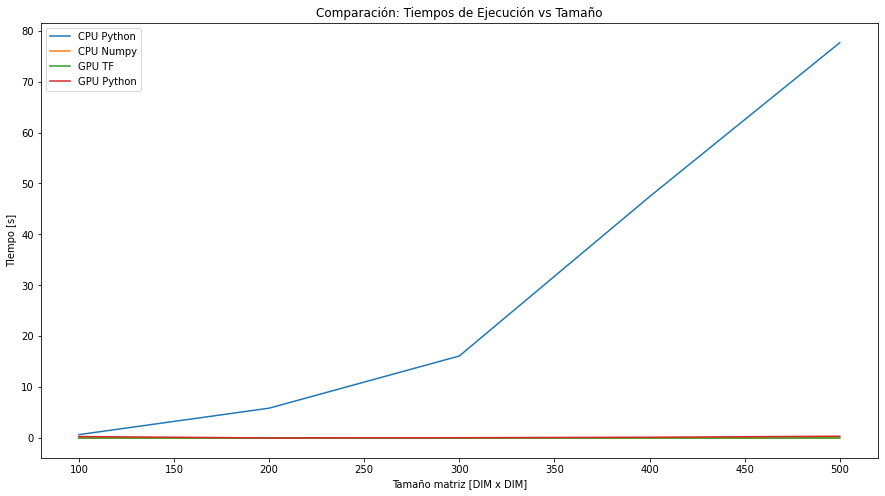

In [17]:
from matplotlib import pyplot as plt

t = list(range(TEST, TEST*STEPS, TEST))
plt.figure(figsize=(15, 8))
plt.plot(t, [i[1][0] for i in times], t, [i[1][1] for i in times], t, [i[1][2] for i in times], t, [i[1][3] for i in times])
plt.title('Comparación: Tiempos de Ejecución vs Tamaño')
plt.ylabel('TIempo [s]')
plt.xlabel('Tamaño matriz [DIM x DIM]')
plt.legend(("CPU Python", "CPU Numpy", "GPU TF", "GPU Python"))

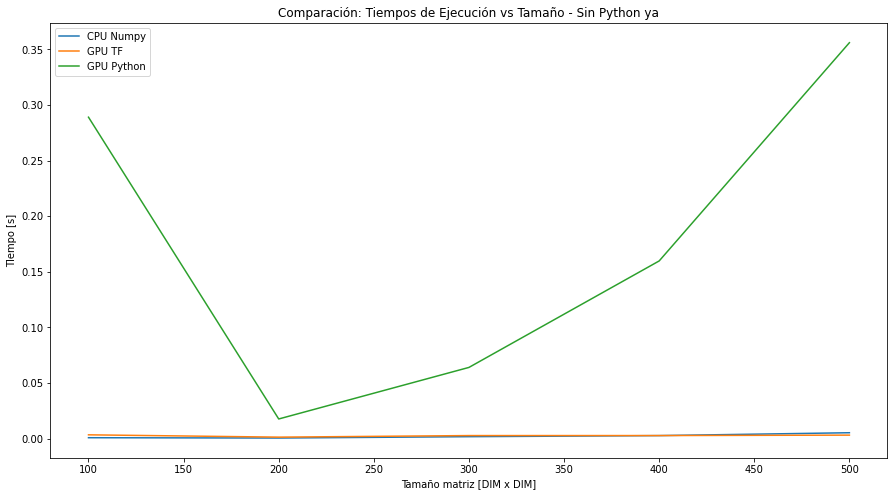

In [18]:
plt.figure(figsize=(15, 8))
plt.plot( t, [i[1][1] for i in times], t, [i[1][2] for i in times], t, [i[1][3] for i in times])
plt.title('Comparación: Tiempos de Ejecución vs Tamaño - Sin Python ya')
plt.ylabel('TIempo [s]')
plt.xlabel('Tamaño matriz [DIM x DIM]')
plt.legend(("CPU Numpy", "GPU TF", "GPU Python"))

## Cambiar a entorno con GPU

In [19]:
TEST = 500
STEPS = 6
times_sin_python = []
for i in range(TEST, TEST*STEPS, TEST):
    a = np.random.rand(i, i)
    b = np.random.rand(i, i)

    total_1 = 0 # Anulado el lento

    inicio = timer()
    result_2 = cpu_by_numpy(a, b)
    total_2 = timer()-inicio

    inicio = timer()
    result_3 = gpu_by_tf(a, b)
    total_3 = timer()-inicio

    inicio = timer()
    result_1_gpu = gpu_by_python(a, b, i)
    total_1_gpu = timer()-inicio
    
    times_sin_python.append((i, (total_1, total_2, total_3, total_1_gpu)))

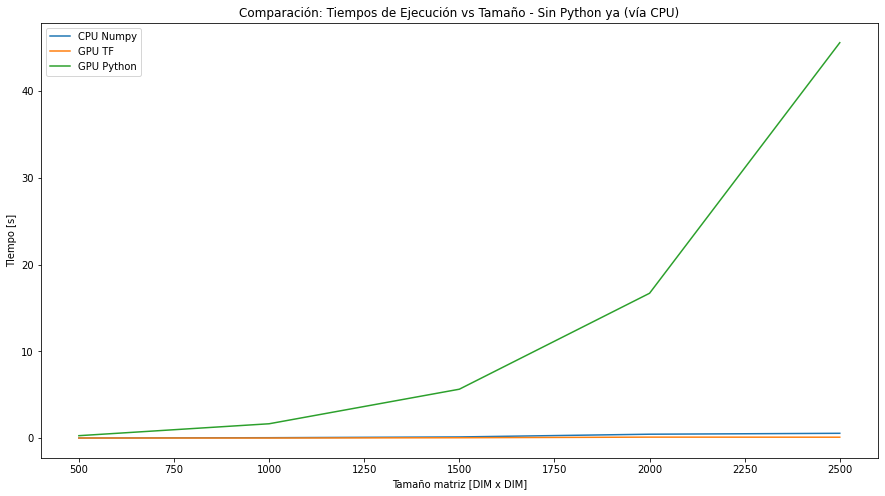

In [20]:
t = list(range(TEST, TEST*STEPS, TEST))

plt.figure(figsize=(15, 8))
plt.plot(t, [i[1][1] for i in times_sin_python], t, [i[1][2] for i in times_sin_python], t, [i[1][3] for i in times_sin_python])
plt.title('Comparación: Tiempos de Ejecución vs Tamaño - Sin Python ya (vía CPU)')
plt.ylabel('TIempo [s]')
plt.xlabel('Tamaño matriz [DIM x DIM]')
plt.legend(("CPU Numpy", "GPU TF", "GPU Python"))

In [21]:
TEST = 500
STEPS = 15 # Con 15, un mituto aprox.
times_mejores = []
for i in range(TEST, TEST*STEPS, TEST):
    a = np.random.rand(i, i)
    b = np.random.rand(i, i)

    total_1 = 0 # Anulado el lento

    inicio = timer()
    result_2 = cpu_by_numpy(a, b)
    total_2 = timer()-inicio

    inicio = timer()
    result_3 = gpu_by_tf(a, b)
    total_3 = timer()-inicio

    total_1_gpu = 0 # Anulado el siguiente lento
    
    times_mejores.append((i, (total_1, total_2, total_3, total_1_gpu)))

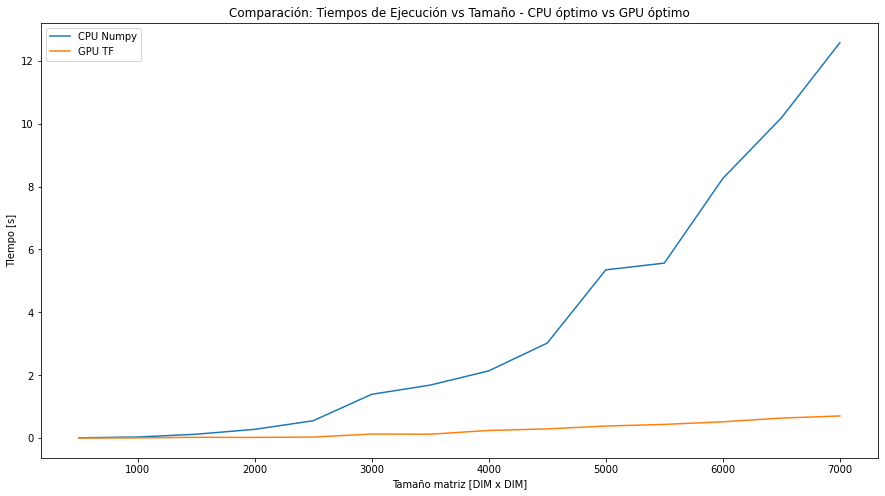

In [22]:
t = list(range(TEST, TEST*STEPS, TEST))

plt.figure(figsize=(15, 8))
plt.plot(t, [i[1][1] for i in times_mejores], t, [i[1][2] for i in times_mejores])
plt.title('Comparación: Tiempos de Ejecución vs Tamaño - CPU óptimo vs GPU óptimo')
plt.ylabel('TIempo [s]')
plt.xlabel('Tamaño matriz [DIM x DIM]')
plt.legend(("CPU Numpy", "GPU TF"))

In [23]:
TEST = 500
STEPS = 30 # Con 30, menos minuto.
times_mejor = []
for i in range(TEST, TEST*STEPS, TEST):
    a = np.random.rand(i, i)
    b = np.random.rand(i, i)

    total_1 = 0 # Anulado el lento

    total_2 = 0 # Anulado el 3ero más lento

    inicio = timer()
    result_3 = gpu_by_tf(a, b)
    total_3 = timer()-inicio

    total_1_gpu = 0 # Anulado el siguiente lento
    
    times_mejor.append((i, (total_1, total_2, total_3, total_1_gpu)))

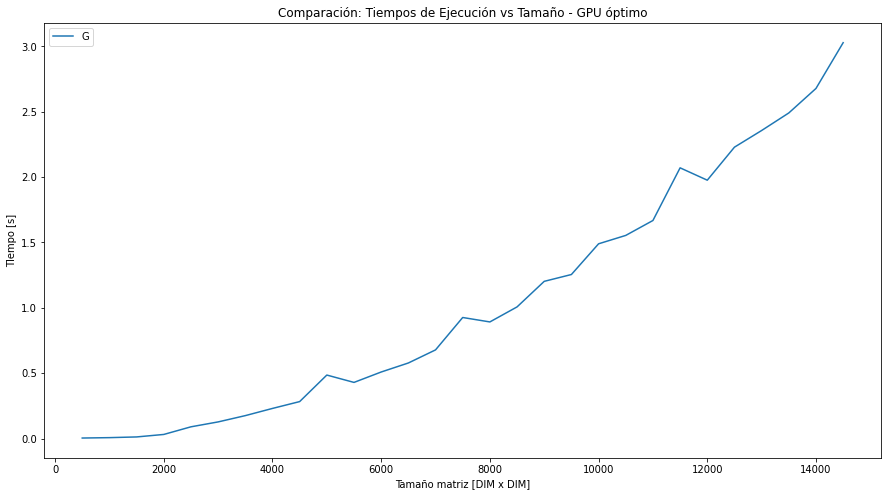

In [24]:
plt.figure(figsize=(15, 8))
plt.plot(list(range(TEST, TEST*STEPS, TEST)), [i[1][2] for i in times_mejor])
plt.title('Comparación: Tiempos de Ejecución vs Tamaño - GPU óptimo')
plt.ylabel('TIempo [s]')
plt.xlabel('Tamaño matriz [DIM x DIM]')
plt.legend(("GPU TF"))